**OBJECTIVE** : Optimize the placement of street teams at subway station entrances, in order to collect email addresses for the client (WTWY)’s annual gala. The goal is to maximize the number of emails collected from people who would be interested either in attending the gala or in contributing to the cause (“target population”).

**DATA** : Our primary source of data is MTA subway data. This gives us information on the flow of people through various stations. This workbook demonstrates how we acquired, processed and scrubbed the data.

In [1]:
import csv
import datetime
import os
import pandas as pd
import sys
from collections import defaultdict
from collections import OrderedDict

Identify MTA data files

In [2]:
# The name and location of MTA turnstile files. Files are published once
# per week on Saturday. For description of file contents, see:
# http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

MTA_FILE_FMT = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_%y%m%d.txt'

In [3]:
def get_urls(n_weeks, start_date=None):
    """Identify MTA turnstile files a specific interval
    
    n_weeks: interval duration, in weeks
    start_date: interval start as datetime, if None function uses today() minus n_weeks 
    
    Returns chronological list of URLs 
    """
    
    ONE_WEEK = datetime.timedelta(days=7)

    # If no start specified, use n_weeks before today

    if None == start_date:
        start_date = datetime.date.today() - n_weeks * ONE_WEEK
        
    # Identify first Saturday on/after specified date

    first_saturday = start_date + datetime.timedelta(days=5 - start_date.weekday())
    
    # Compose list of requested dates
    
    dates = [first_saturday + ONE_WEEK * i for i in range(n_weeks)]
    
    # Return file names sorted chronolo
    
    return [d.strftime(MTA_FILE_FMT) for d in dates]

In [4]:
# Test it
for f in get_urls(4, datetime.datetime(2016, 6, 1)):
    print f

http://web.mta.info/developers/data/nyct/turnstile/turnstile_160604.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_160611.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_160618.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_160625.txt


Get data for Spring 2016 (as Gala is scheduled for the beginning of summer, so assume teams will
be deployed in mid- / late- Spring)

Convert the raw data to something more useful:
- Collapse the rows into a dictionary that maps each STATION to the aggregate entry/exit data for all turnstiles 
- Remove invalid values and outliers

In [5]:
def load_data(n_weeks=4, start_date=None):
    """Load MTA turnstile data for a specific interval
    
    start_date: interval start
    n_weeks: interval duration, in weeks
    
    Returns date frame
    """
    # Get files to read

    frames = []
    for url in get_urls(n_weeks, start_date):
    
        # If the file exists locally, use it
        name = os.path.basename(url)
        if os.path.exists(name):
            print 'reading local:', name
            frames.append(pd.read_csv(name))
        else:            
            # Otherwise, download it ...
            print 'reading url:', url
            frames.append(pd.read_csv(url))
            # ...  and save a copy for the next time
            frames[-1].to_csv(name, index=False)

    return pd.concat(frames)

In [6]:
def make_dict(df):
    """Convert turnstile data frame to dictionary that maps each STATION
    to a list of { DATE : [TIME, ENTRIES, EXITS], ... } values

    df: Pandas data frame with raw turnstile data
    """

    # Build dictionary

    d = OrderedDict()
    for row in df.values:
        key = tuple(row[:4]) # this is (C/A, UNIT, SCP, STATION)
        date, time, entries, exits = (row[6], row[7], row[9], row[10])
        dt = datetime.datetime.strptime(date + time, '%m/%d/%Y%H:%M:%S')
        # Turnstile data is by the hour, only accept data that fits the
        # expected pattern
        if 0 == dt.minute + dt.second:
            d.setdefault(key, []).append([dt, entries, exits])

    # Here 'd' is:
    # { (C/A, UNIT, SCP, STATION) : [[DATE-TIME, ENTRIES, EXITS], ...]}

    # Convert cumulative counts to deltas
    
    for key, counts in d.items():
        for i in range(len(counts) - 1, 0, -1):
            dt1, entries1, exits1 = tuple(counts[i])
            dt2, entries2, exits2 = tuple(counts[i-1])
            # Turnstile data comes in 4-hour intervals. To get the deltas,
            # subtract each count from the preceeding interval. Use the
            # asbolute value because some turnstiles run backwards. When 
            # there's no preceeding interval, zero the count.
            if dt1 == dt2 + datetime.timedelta(hours=4):
                counts[i][1] = abs(entries1 - entries2) # handle negative deltas
                counts[i][2] = abs(exits1 - exits2)
            else:
                counts[i][1] = 0
                counts[i][2] = 0
        counts.pop(0) # Discard first element: there's nothing preceding it.

    # Here 'd' is:
    # { (C/A, UNIT, SCP, STATION) : [[DATE-TIME, DELTA-ENTRIES, DELTA-EXITS], ...]}

    # Exclude large outliers from dictonary

    cleaned = OrderedDict()
    for key, counts in d.items():
        for vals in counts:
            entries, exits = (vals[1], vals[2])
            if entries < 50000 and exits < 50000:
                cleaned.setdefault(key, []).append(vals)

    # Aggregate the deltas by STATION and DATE-TIME

    agg = OrderedDict()
    for key, counts in cleaned.items():
        station = key[3]
        for vals in counts:
            dt = vals[0]
            agg.setdefault((station, dt), []).append(vals[1:])

    # Here 'agg' is:
    # { (STATION, DATE-TIME) : [[DELTA-ENTRIES, DELTA-EXITS], ...]}

    d = OrderedDict()
    for key, counts in agg.items():
        station, dt = key
        entries, exits = zip(*counts)
        d.setdefault(station, []).append([dt.date(), dt.weekday(), dt.hour, sum(entries), sum(exits)])
    
    # Here 'd' is:
    # { STATION : [DATE, WEEKDAY (0=Monday), HOUR (0-23), SUM(DELTA-ENTRIES), SUM(DELTA-EXITS)] }

    return d

In [7]:
def dataframe_from_dict(d):
    """Convert turnstile data dictionary to data frame.

    d: dictionary like { STATION : [[DATE, DAY, TIME, ENTRIES, EXITS], ...] }
    """
    flattened = []
    for station, tally in d.items():
        for data in tally:
            flattened.append([station] + data)
    return pd.DataFrame(flattened, columns=['STATION', 'DATE', 'DAY', 'TIME', 'ENTRIES', 'EXITS'])

In [8]:
start_week = datetime.date(2016, 3, 15)
week_count = 12

In [9]:
# If the data file already exists, use it. Otherwise, create it.
filename = 'mta-spring2016-rev01.csv'
if os.path.exists(filename):
    print 'reading cached:', filename
    df = pd.read_csv(filename)
else:
    print 'creating:', filename
    raw_df = load_data(week_count, start_week)
    # Convert the data
    d = make_dict(raw_df)
    # Save the results
    df = dataframe_from_dict(d)
    df.to_csv(filename, index=False)

reading cached: mta-spring2016-rev01.csv


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195019 entries, 0 to 195018
Data columns (total 6 columns):
STATION    195019 non-null object
DATE       195019 non-null object
DAY        195019 non-null int64
TIME       195019 non-null int64
ENTRIES    195019 non-null int64
EXITS      195019 non-null int64
dtypes: int64(4), object(2)
memory usage: 8.9+ MB


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandasql as pdsql
import seaborn as sns
from IPython.display import Image
%matplotlib inline

In [12]:
pysql = lambda q: pdsql.sqldf(q, globals())
pd.options.display.float_format = '{:,.2f}'.format
subway = df

In [13]:
# total flow grouped by station ordered by exits(decsending)
    
query = "select station, sum(entries), sum(exits) \
    from subway group by station \
    order by sum(exits) desc"
df = pysql(query)
df.head()

,STATION,sum(entries),sum(exits)
0,34 ST-PENN STA,12476632,10648177
1,GRD CNTRL-42 ST,10618672,9428334
2,34 ST-HERALD SQ,9109199,8007551
3,14 ST-UNION SQ,8098847,6958567
4,86 ST,8150360,6854298


<Container object of 10 artists>

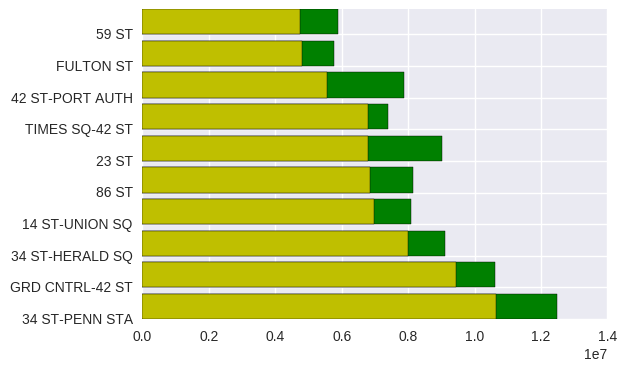

In [22]:
df_allstations = df[:10]
df_allstations.describe()
x = range(0, len(df_allstations['sum(entries)']))
plt.figure(1)
plt.yticks(x,df_allstations['STATION'])
plt.barh(x, df_allstations['sum(entries)'], color='g',label = 'entries',)
plt.barh(x, df_allstations['sum(exits)'], color='y',label = 'exits')

#plt,xlabel('Total Commuter Flow')
#plt.title('Total Commuter Flow: Ranked by Station')
#plt.show()